### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Import data into tensorflow dataset object

In [2]:
# Constants
IMAGE_SIZE = 224  # Replace with your desired image size
BATCH_SIZE = 32
DATASET_DIR = '/kaggle/input/tomatoleaf/Dataset3'  # Path to your dataset directory
CLASS_NAMES = os.listdir(DATASET_DIR)

# Prepare a list of all image paths and corresponding labels
image_paths = []
labels = []

for class_name in CLASS_NAMES:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

# Create a DataFrame
data = pd.DataFrame({'image_path': image_paths, 'label': labels})


In [3]:
# Split into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.1, stratify=data['label'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, stratify=train_data['label'], random_state=42)  # 0.25 x 0.8 = 0.2


In [4]:
# Data Augmentation and Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important to maintain order for evaluation
)

Found 25618 validated image filenames belonging to 11 classes.
Found 3660 validated image filenames belonging to 11 classes.
Found 3254 validated image filenames belonging to 11 classes.


In [5]:
# Get class indices
class_indices = train_generator.class_indices

# Map class names to their image counts
class_counts_dict = train_data['label'].value_counts().to_dict()

# Create a list of counts in the order of train_generator.class_indices
ordered_counts = [(class_name, class_counts_dict.get(class_name, 0)) for class_name in class_indices.keys()]

# Convert to a DataFrame for better visualization
ordered_counts_df = pd.DataFrame(ordered_counts, columns=['Class Name', 'Image Count'])

# Print the ordered counts
print(ordered_counts_df)



                              Class Name  Image Count
0                         Bacterial_spot         2802
1                           Early_blight         2439
2                            Late_blight         3075
3                              Leaf_Mold         2751
4                     Septoria_leaf_spot         2857
5   Spider_mites Two-spotted_spider_mite         1718
6                            Target_Spot         1799
7          Tomato_Yellow_Leaf_Curl_Virus         1996
8                    Tomato_mosaic_virus         2155
9                                healthy         3037
10                        powdery_mildew          989


In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
]

## Building the Model

In [8]:
from tensorflow.keras.models import Model
from keras.layers import Flatten, Dense,TimeDistributed,Conv2D,MaxPooling2D,LSTM,Dropout,Reshape,Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2 

strategy=tf.distribute.MirroredStrategy()
with strategy.scope():
    
    model = Sequential()
   
    # Reshaping the image into a sequence
    model.add(Reshape((224,224*3), input_shape=(224, 224, 3)))    #112->Reduced Time Steps→ Allows LSTMs to learn more efficiently.
    #Higher Feature Dimension per Step (1344 Instead of 672) → Each time step gets more meaningful information.
    
    # LSTM layers
    # model.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model.add(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model.add(LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))
    
    # Dense Layers for Classification
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(11, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])
print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 224, 672)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 224, 64)             │         188,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,731 (807.54 KB)

 Trainable params: 206,731 (807.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
history = model.fit(
    train_generator,
    batch_size=BATCH_SIZE ,
    # steps_per_epoch = steps_per_epoch,  # Total samples / batch_size
    validation_data=validation_generator,
    # validation_steps = validation_steps,
    epochs=30,
    callbacks = callbacks
)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
801/801 ━━━━━━━━━━━━━━━━━━━━ 696s 853ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1094 - loss: 2.4319 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.1251 - val_loss: 2.3912 - learning_rate: 1.0000e-04
Epoch 2/30
801/801 ━━━━━━━━━━━━━━━━━━━━ 686s 852ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1321 - loss: 2.3869 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.1749 - val_loss: 2.3053 - learning_rate: 1.0000e-04
Epoch 3/30
801/801 ━━━━━━━━━━━━━━━━━━━━ 678s 843ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1480 - loss: 2.3456 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2301 - val_loss: 2.2272 - learning_rate: 1.0000e-04
Epoch 4/30
801/801 ━━━━━━━━━━━━━━━━━━━━ 680s 845ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1729 - loss: 2.2855 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.2503 - val_loss: 2.1

In [11]:
# Evaluate on train data
train_scores = model.evaluate(train_generator, verbose=0)
print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]:.4f}, Train Precision: {train_scores[2]:.4f},Train Recall: {train_scores[3]:.4f}")

Train Loss: 1.5646, Train Accuracy: 0.4490, Train Precision: 0.7636,Train Recall: 0.1429


In [12]:

# Evaluate on test data
test_scores = model.evaluate(test_generator,verbose=0)
print(f"Test Loss: {test_scores[0]:.4f}, Test Accuracy: {test_scores[1]:.4f},Test Precision: {test_scores[2]:.4f},Test Recall: {test_scores[3]:.4f}")

Test Loss: 1.5016, Test Accuracy: 0.4677,Test Precision: 0.7932,Test Recall: 0.1580


In [13]:
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, f1_score

y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class indices


102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 244ms/step


In [14]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


Classification Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.49      0.38      0.43       356
                        Early_blight       0.39      0.33      0.36       310
                         Late_blight       0.35      0.29      0.32       391
                           Leaf_Mold       0.74      0.29      0.41       349
                  Septoria_leaf_spot       0.39      0.47      0.42       363
Spider_mites Two-spotted_spider_mite       0.38      0.47      0.42       218
                         Target_Spot       0.44      0.51      0.47       228
       Tomato_Yellow_Leaf_Curl_Virus       0.64      0.76      0.70       253
                 Tomato_mosaic_virus       0.63      0.80      0.71       274
                             healthy       0.46      0.66      0.54       386
                      powdery_mildew       0.32      0.21      0.25       126

                            accuracy   

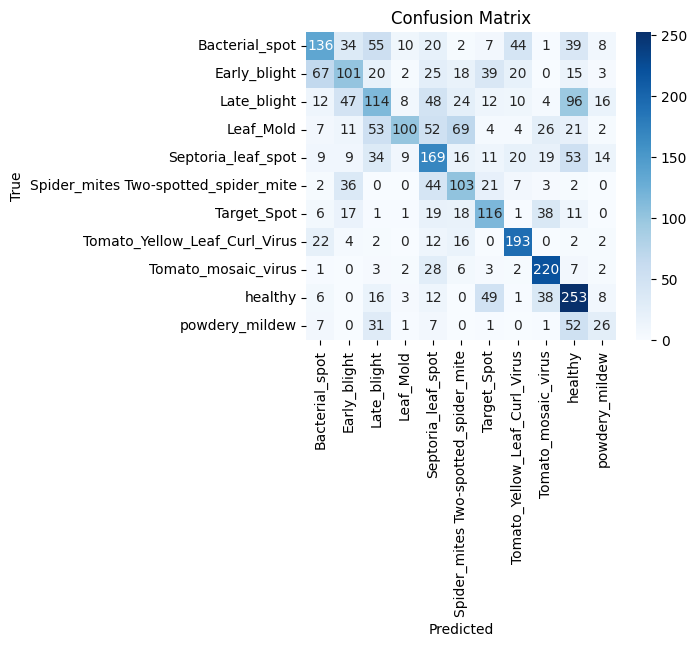

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [16]:
overall_accuracy = accuracy_score(y_true, y_pred)
overall_precision = precision_score(y_true, y_pred, average='macro')  # Weighted average for class imbalance
overall_recall = recall_score(y_true, y_pred, average='macro')
overall_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")

Overall Accuracy: 0.4705
Overall Precision: 0.4747
Overall Recall: 0.4691
Overall F1-Score: 0.4566


In [17]:
specificity = []

for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))

overall_specificity = np.mean(specificity)  # Average specificity

print(f"Overall Specificity: {overall_specificity:.4f}")

Overall Specificity: 0.9466


In [18]:
# Sensitivity (Recall)
def calculate_specificity(cm, CLASS_NAMES):

    # Specificity
    specificity = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity.append(tn / (tn + fp))

    print("\nPer-Class Specificity:")
    for idx, class_name in enumerate(CLASS_NAMES):
        print(f"Class {class_name}: {specificity[idx]:.4f}")

    return specificity

In [19]:
# print("\n--- Train Data Metrics ---")
specificity = calculate_specificity(cm, CLASS_NAMES)


Per-Class Specificity:
Class Late_blight: 0.9520
Class Tomato_Yellow_Leaf_Curl_Virus: 0.9463
Class Septoria_leaf_spot: 0.9249
Class Early_blight: 0.9876
Class Spider_mites Two-spotted_spider_mite: 0.9076
Class powdery_mildew: 0.9443
Class healthy: 0.9514
Class Bacterial_spot: 0.9637
Class Target_Spot: 0.9564
Class Tomato_mosaic_virus: 0.8961
Class Leaf_Mold: 0.9824


In [20]:
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Create a DataFrame for the class-wise accuracies
class_accuracy_df = pd.DataFrame({
    "Class": list(test_generator.class_indices.keys()),
    "Accuracy": class_accuracies
})

print("\nClass-wise Accuracies:")
print(class_accuracy_df.to_string(index=False))


Class-wise Accuracies:
                               Class  Accuracy
                      Bacterial_spot  0.382022
                        Early_blight  0.325806
                         Late_blight  0.291560
                           Leaf_Mold  0.286533
                  Septoria_leaf_spot  0.465565
Spider_mites Two-spotted_spider_mite  0.472477
                         Target_Spot  0.508772
       Tomato_Yellow_Leaf_Curl_Virus  0.762846
                 Tomato_mosaic_virus  0.802920
                             healthy  0.655440
                      powdery_mildew  0.206349


### Run prediction on a sample image

In [21]:
import random
from tensorflow.keras.preprocessing import image

random_indices = random.sample(range(len(y_true)), 15)

class_names = list(test_generator.class_indices.keys())

# Iterate through the random indices and display actual and predicted results
for idx in random_indices:
    actual_class = class_names[y_true[idx]]
    predicted_class = class_names[y_pred[idx]]
    print(f"Actual: {actual_class} ,  Predicted: {predicted_class}")

Actual: Late_blight ,  Predicted: healthy
Actual: Bacterial_spot ,  Predicted: Bacterial_spot
Actual: Bacterial_spot ,  Predicted: powdery_mildew
Actual: Tomato_mosaic_virus ,  Predicted: Tomato_mosaic_virus
Actual: Leaf_Mold ,  Predicted: Spider_mites Two-spotted_spider_mite
Actual: Late_blight ,  Predicted: Spider_mites Two-spotted_spider_mite
Actual: Tomato_mosaic_virus ,  Predicted: Tomato_mosaic_virus
Actual: healthy ,  Predicted: healthy
Actual: Tomato_mosaic_virus ,  Predicted: Tomato_mosaic_virus
Actual: Early_blight ,  Predicted: Spider_mites Two-spotted_spider_mite
Actual: Late_blight ,  Predicted: healthy
Actual: Spider_mites Two-spotted_spider_mite ,  Predicted: Early_blight
Actual: Spider_mites Two-spotted_spider_mite ,  Predicted: Target_Spot
Actual: Septoria_leaf_spot ,  Predicted: Early_blight
Actual: Late_blight ,  Predicted: healthy
